In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [9]:
# Load the CSV files
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Display the first few rows of each dataset to verify successful loading
print(customers_df.head())
print(products_df.head())
print(transactions_df.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [11]:
# Basic Data Exploration
# Check for missing values
print(customers_df.isnull().sum())
print(products_df.isnull().sum())
print(transactions_df.isnull().sum())

# Summary statistics for numerical data
print(customers_df.describe())
print(products_df.describe())
print(transactions_df.describe())


CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64
       CustomerID    CustomerName         Region  SignupDate
count         200             200            200         200
unique        200             200              4         179
top         C0185  Kathleen Logan  South America  2022-04-16
freq            1               1             59           3
            Price
count  100.000000
mean   267.551700
std    143.219383
min     16.080000
25%    147.767500
50%    292.875000
75%    397.090000
max    497.760000
          Quantity   TotalValue       Price
count  1000.000000  1000.000000  1000.00000
mean      2.537000   689.995560   272.55407
std       1.117981   493.144478   140.73639
min       1.000000    16.080000

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


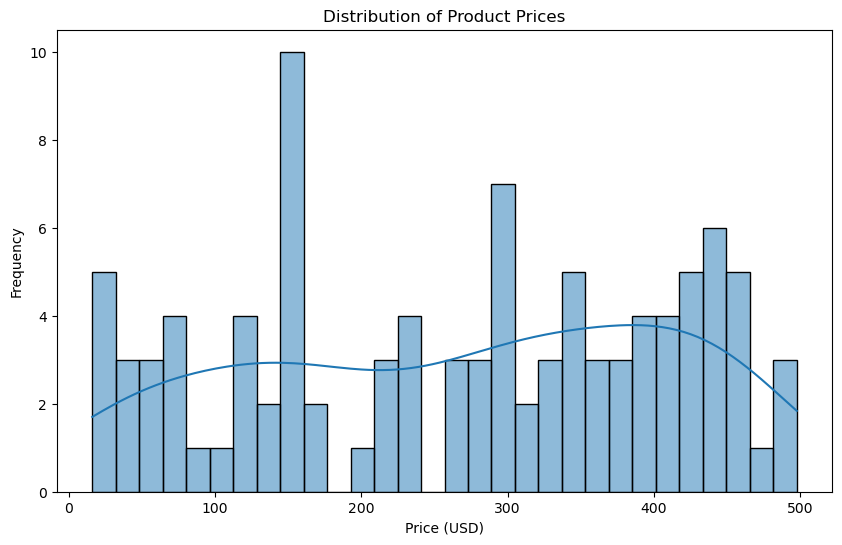

In [43]:
# Visualizing the distribution of product prices
#To get an insight into the distribution of product prices, use a histogram.
plt.figure(figsize=(10, 6))
sns.histplot(products_df['Price'], bins=30, kde=True)
plt.title('Distribution of Product Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
#Lookalike Model
#This part of the assignment involves creating a Lookalike Model.

In [45]:
# Aggregate data for each customer (total spent, number of transactions, average transaction value)
customer_data = transactions_df.groupby('CustomerID').agg(
    total_spent=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    num_transactions=pd.NamedAgg(column='TransactionID', aggfunc='count'),
    avg_transaction_value=pd.NamedAgg(column='TotalValue', aggfunc='mean')
).reset_index()

# Merge with customer information (e.g., Region)
customer_data = pd.merge(customer_data, customers_df[['CustomerID', 'Region']], on='CustomerID', how='left')
print(customer_data.head())


  CustomerID  total_spent  num_transactions  avg_transaction_value  \
0      C0001      3354.52                 5                670.904   
1      C0002      1862.74                 4                465.685   
2      C0003      2725.38                 4                681.345   
3      C0004      5354.88                 8                669.360   
4      C0005      2034.24                 3                678.080   

          Region  
0  South America  
1           Asia  
2  South America  
3  South America  
4           Asia  


In [47]:
# Normalize the data before calculating similarity
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['total_spent', 'num_transactions', 'avg_transaction_value']])

# Calculate cosine similarity
similarity_matrix = cosine_similarity(scaled_data)

# Create a DataFrame for easier access to similar customers
similarity_df = pd.DataFrame(similarity_matrix, columns=customer_data['CustomerID'], index=customer_data['CustomerID'])

# Get the top 3 similar customers for each of the first 20 customers
lookalike_recommendations = {}
for customer in customer_data['CustomerID'][:20]:
    top_similar = similarity_df[customer].sort_values(ascending=False).iloc[1:4]
    lookalike_recommendations[customer] = top_similar

# Save recommendations to CSV
lookalike_df = pd.DataFrame.from_dict(lookalike_recommendations, orient='index')
lookalike_df.to_csv('Lookalike.csv')


In [ ]:
#Clustering Customers (Segmentation)
#For customer segmentation, you can perform clustering using KMeans.

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Davies-Bouldin Index: 0.9243980866225234


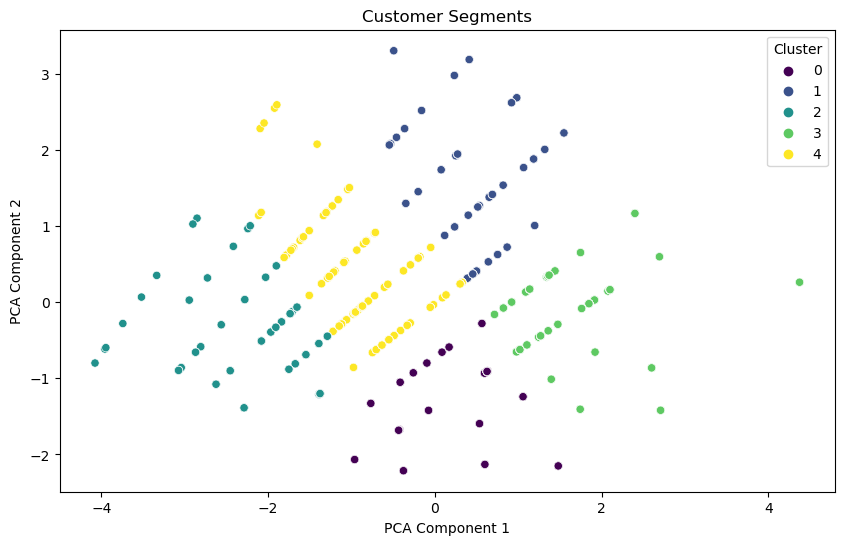

In [49]:
# Merge customer data with transaction data for clustering
clustering_data = pd.merge(customer_data, transactions_df, on='CustomerID')

# Select relevant features for clustering
clustering_features = clustering_data[['total_spent', 'num_transactions', 'avg_transaction_value']]

# Normalize data
scaler = StandardScaler()
scaled_clustering_data = scaler.fit_transform(clustering_features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clustering_data['Cluster'] = kmeans.fit_predict(scaled_clustering_data)

# Calculate Davies-Bouldin Index
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(scaled_clustering_data, clustering_data['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_clustering_data)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=clustering_data['Cluster'], palette='viridis')
plt.title('Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [51]:
lookalike_df.to_csv('Lookalike.csv')
